# Archivos de entrada para IPF-FDMC

El código de onda completa IPF-FDMC necesita de un mapa de contorno de la densidad electrónica y un mapa de contorno del campo magnético. A continuación se realizan todos los pasos necesarios para ello.

In [1]:
#librerías
import numpy as np
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
from scipy.interpolate import griddata #interpolación 2
import h5py #archivos en hdf5
from jupyterlab_h5web import H5Web #librería
from pathlib import Path, PurePath #manejo de rutas y archivos
ruta = '/home/rich12/Nube/Tesis/Final_23_03_23_Resultados/Escenarios/Escenario_2 (aumento en campo)'
archivo_py = 'Funciones.py'
ruta_funciones = PurePath(Path(ruta), Path(archivo_py))
%run -i "{ruta_funciones}" #funciones importante

(98, 40, 48)


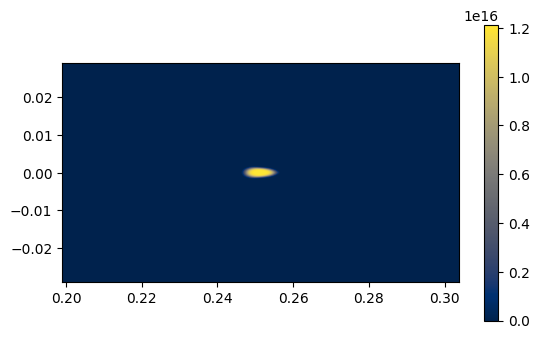

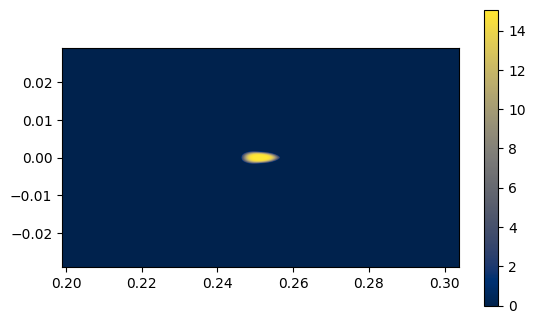

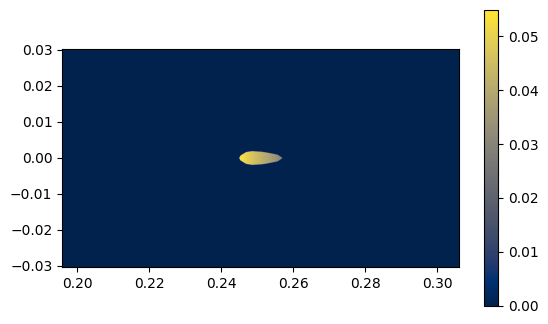

In [2]:
#Seleccionar el ajuste en z para definir nuevos inputs
ruta_campo = PurePath(Path(ruta), Path('ne_Te_r_z_B/r+z+B_mag_componentes.txt'))
ruta_ne = PurePath(Path(ruta), Path('ne_Te_r_z_B/densidad.txt'))
ruta_Te = PurePath(Path(ruta), Path('ne_Te_r_z_B/temperatura.txt'))

n_e = np.loadtxt(ruta_ne)
T_e = np.loadtxt(ruta_Te)
r_BS, z_BS1, B_x,B_y,B_z = np.loadtxt(ruta_campo, usecols=(0, 1, 2, 3, 4), unpack=True)

r_vmec, z_vmec = variables_vmec(PurePath(Path(ruta), Path('input_VMEC')), 'wout_scr_free.nc')
r,z = eliminar_eje_magnetico(r_vmec, z_vmec)
z = z + 0.00 # Posición correcta en el output final (suma - bajar y menos - subir)
z_BS = z_BS1 - 0.00 #intercambiar signo con z

s2DB = campo_magnetico_mapa(r_BS, z_BS)
superficie_2D, ne1, Te1 = densidad_electronica_mapa(r,z,n_e, T_e)
ne_interpol = input_densidad_hdf5(superficie_2D, ne1)
Te_interpol = input_densidad_hdf5(superficie_2D, Te1)
B_xint, B_yint, B_zint = input_campo_hdf5(s2DB, B_x, B_y, B_z)

## Exportar archivos a hdf5

In [3]:
#Escenario 2
#factor_B = 0.95
factor_B = 0.975
#factor_B = 1.00
#factor_B = 1.0225
#factor_B = 1.05
#factor_B = 1.009

#hdf5 campo magnético
#Se divide entre dos veces el campo magnético resonante
with h5py.File('magneticfield.h5', 'w' ) as h5file:
    h5file['X magnetic field'] = np.abs(factor_B*B_yint/ 43.8e-3)
    h5file['Y magnetic field'] = np.abs(factor_B*B_xint/ 43.8e-3)
    h5file['Z magnetic field'] = np.abs(factor_B*B_zint/ 43.8e-3)

In [4]:

factor_densidad = 6.1405*2.14

#Factores adicionales
#factor_densidad = 6.1405*1.480
#factor_densidad = 6.1405*1.573
#factor_densidad = 6.1405*1.665
#factor_densidad = 6.1405*1.758
#factor_densidad = 6.1405*1.850
#factor_densidad = 6.1405*1.995
#factor_densidad = 6.1405*2.068

#hdf5 densidad
with h5py.File('Density.h5', 'w') as h5file:
    h5file['Density'] = (factor_densidad*ne_interpol/7.45e16)

In [ ]:
# Visualización del hdf5
from jupyterlab_h5web import H5Web #librería
H5Web('Density.h5')
#H5Web('magneticfield.h5')
#H5Web('Density_vessel.h5')
#H5Web('Density_vc.h5')